## Bayes Filter Implementation

Author: Vishwas Hegde

Date: 27 Jan 2024


# Task 1: Analyzing Sensor and Propagation Models

## Sensor Model:

The sensor (measurement) model described in Equation 1 tells us that the robot's camera has moderate reliability. Although the robot senses the door to be closed well with a probability of 0.8, the probability to sense the door to be open when it is open is 0.6 rendering the system to have false positive results.
The noise can be modeled as conditional probabilities:

\begin{align*}
p(Z_t = \text{sense open} \mid X_t = \text{is open}) &= 0.6 \\
p(Z_t = \text{sense closed} \mid X_t = \text{is open}) &= 0.4 \\
p(Z_t = \text{sense open} \mid X_t = \text{is closed}) &= 0.2 \\
p(Z_t = \text{sense closed} \mid X_t = \text{is closed}) &= 0.8 \\
\end{align*}


## Propagation Model:

$p(x_t|u_t, x_{t-1})$ represents the probability of the door being in state $x_t$ at time $t$, given the action $u_t$ at time $t$ and the previous state $x_{t-1}$.

If the action is Push
\begin{align*}
p(X_t = \text{is open} \mid U_t = \text{push}; X_{t-1} = \text{is open}) &= 1 \\
p(X_t = \text{is closed} \mid U_t = \text{push}; X_{t-1} = \text{is open}) &= 0 \\
p(X_t = \text{is open} \mid U_t = \text{push}; X_{t-1} = \text{is closed}) &= 0.8 \\
p(X_t = \text{is closed} \mid U_t = \text{push}; X_{t-1} = \text{is closed}) &= 0.2 \\
\end{align*}

If the robot decides to do_nothing
\begin{align*}
p(X_t = \text{is open} \mid U_t = \text{do nothing}, X_{t-1} = \text{is open}) &= 1 \\
p(X_t = \text{is closed} \mid U_t = \text{do nothing}, X_{t-1} = \text{is open}) &= 0 \\
p(X_t = \text{is open} \mid U_t = \text{do nothing}, X_{t-1} = \text{is closed}) &= 0 \\
p(X_t = \text{is closed} \mid U_t = \text{do nothing}, X_{t-1} = \text{is closed}) &= 1 \\
\end{align*}


## System Dynamics:

This model highlights the probabilities of the system when no action is taken and when the door is pushed. Further, pushing affects the state only when the door is closed.


## Task 2: Implementation of the Bayes Filter Algorithm

In [1]:
# Defining probabilities 

prob_z = {"sense_open":{"is_open" : 0.6, "is_closed":0.2}, "sense_closed":{"is_open" : 0.4, "is_closed":0.8}}  # P(Zt|Xt)
prob_x = {"is_open" : {"push" : {"is_open" : 1, "is_closed" : 0.8}, "do_nothing" : {"is_open" : 1, "is_closed": 0}},  
          "is_closed" : {"push" : {"is_open" : 0, "is_closed" : 0.2}, "do_nothing" : {"is_open" : 0, "is_closed": 1}}}    #P(Xt|Ut,Xt-1)

In [2]:
def predict(action, initial_belief=None):
    '''Predict the states based on sensor measurements
    Input
        action: Push/Do_Nothing
        initial_belief: belief of previous step
    Output
        probability of predicted states [open, close]
    '''
    pred_open = (prob_x['is_open'][action]['is_open'] * initial_belief[0]
                + prob_x['is_open'][action]['is_closed'] * initial_belief[1])
    pred_closed = (prob_x['is_closed'][action]['is_open'] * initial_belief[0]
                 + prob_x['is_closed'][action]['is_closed'] * initial_belief[1])

    return [pred_open, pred_closed]

In [3]:
def update(pred, sense = None):
    '''Update the states of the robot
    Input 
        pred: Input from prediction step
        sense: sense_open/sense_close
    Output
        Updated probability of states [open, close]
    '''
    x_open = prob_z[sense]['is_open'] * pred[0] 
    x_closed = prob_z[sense]['is_closed'] * pred[1]

    normalize = 1/(x_open + x_closed)   # Normalize the probabilities to ensure they sum to 1

    return [x_open * normalize, x_closed * normalize]

It took 9 Iterations taken to achieve 99.99% certainity


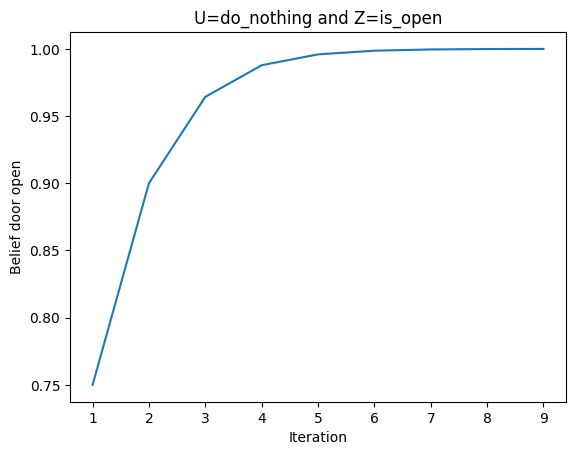

In [4]:
# Task 2
# Subsection 1

import matplotlib.pyplot as plt

initial_belief = [0.5, 0.5]
belief_pattern = []   # List to record change in belief

while initial_belief[0] < 0.9999:
    # Loop until the belief of door open is atleast 99.99%
    pred = predict('do_nothing', initial_belief)    # predict the states
    initial_belief = update(pred, 'sense_open')     # update the initial belief
    belief_pattern.append(initial_belief[0])

print("It took %d Iterations taken to achieve 99.99%% certainity"%len(belief_pattern))

#Plot the results
x_values = list(range(1, len(belief_pattern) + 1))
plt.plot(x_values, belief_pattern)
plt.xlabel('Iteration')
plt.ylabel('Belief door open')
plt.title('U=do_nothing and Z=is_open')
plt.show()


It took 4 Iterations taken to achieve 99.99% certainity


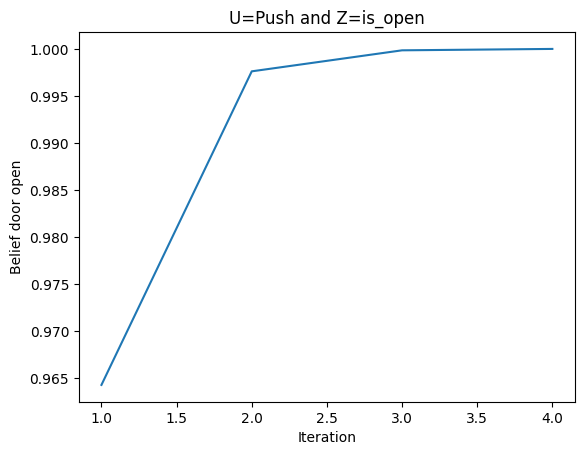

In [5]:
# Task 2
# Subsection 2

initial_belief = [0.5, 0.5]
belief_pattern = []  # List to record change in belief

while initial_belief[0] < 0.9999:
    # Loop until the belief of door open is atleast 99.99%
    pred = predict('push', initial_belief)                            # predict the states
    initial_belief = update(pred, 'sense_open')                       # update the initial belief
    belief_pattern.append(initial_belief[0])

print("It took %d Iterations taken to achieve 99.99%% certainity"%len(belief_pattern))

#Plot the results
x_values = list(range(1, len(belief_pattern) + 1))
plt.plot(x_values, belief_pattern)
plt.xlabel('Iteration')
plt.ylabel('Belief door open')
plt.title('U=Push and Z=is_open')
plt.show()

It took 10 Iterations taken to achieve steady state
Final Belief is 0.999955


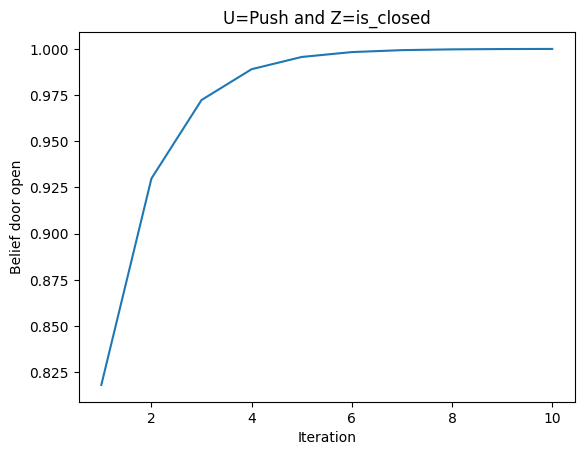

In [6]:
# Task 2
# Subsection 3

initial_belief = [0.5, 0.5]
belief_pattern = []            # List to record change in belief
tolerance = 0.0001             # Set tolerance to check steady state
rel_change = tolerance + 1     # Set change in belief, a value greater than tolerance
iterations = 0 
max_iter = 1000

while iterations < max_iter and rel_change > tolerance:
    # Loop until the relative change of belief is less than tolerance
    prev_belief = initial_belief[0]
    pred = predict('push', initial_belief)
    initial_belief = update(pred, 'sense_closed')
    
    rel_change = abs(prev_belief - initial_belief[0])    # Computer relative change in belief
    belief_pattern.append(initial_belief[0])

    iterations += 1

print("It took %d Iterations taken to achieve steady state"%len(belief_pattern))
print("Final Belief is %f"%belief_pattern[-1])

# Plot the results
x_values = list(range(1, len(belief_pattern) + 1))
plt.plot(x_values, belief_pattern)
plt.xlabel('Iteration')
plt.ylabel('Belief door open')
plt.title('U=Push and Z=is_closed')
plt.show()